In [232]:
#imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import random

#seed for reproducibility
random.seed(0)

In [2]:
#constants
steps = 100
agents = 50
tau = 0.8

stable = 0
low = 1
high = 2

payoff = [1,40,80]
probability = [1,0.5,0.25]

last = -1

sample_size = 10000

In [164]:
#agent class definitions

#base class
class agent:
    def update(self, hist):
        return stable

#always stays in the stable pool
class stableagent(agent):
    def update(self, hist):
        return stable

#always stays in the low pool
class lowagent(agent):
    def update(self, hist):
        return low
        
#always stays in the high pool
class highagent(agent):
    def update(self, hist):
        return high
       
#randomly chooses between not moving and moving to a random pool based on the value of tau
class randomagent(agent):
    def __init__(self):
        self.choices = list()
    def update(self, hist):
        if (not self.choices) or random.random() > tau:
            choice = random.choice([0,1,2])
            self.choices.append(choice)
            return choice
        else:
            self.choices.append(self.choices[last])
            return self.choices[last]
        
#makes the markov assumption and infers a normal distribution from the available data to make a decision
class bayesianagent(agent):
    def __init__(self):
        self.choices = list()
    def update(self, hist):
        if  len(hist) < 2:
            self.choices.append(low)
            return low
        else:
            lowmean = np.mean([t[low] for t in hist])
            highmean = np.mean([t[high] for t in hist])
            
            if lowmean > 20 and highmean > 20:
                self.choices.append(stable)
                return stable
            
            try:
                lastpay = probability[self.choices[last]] * payoff[self.choices[last]] / hist[self.choices[last]][last]
            except IndexError:
                print(len(probability))
                print(len(self.choices))
                print(len(payoff))
                print(len(hist))
                lastpay = 1
                
            if lowmean < highmean and 20 / lowmean > lastpay + tau:
                self.choices.append(low)
                return low
            if highmean < lowmean and 20 / highmean > lastpay + tau:
                self.choices.append(high)
                return high
                
            return self.choices[last]

#tries to keep the system at equilibrium, designed to simulate "typical" rational agent behavior
class nashagent(agent):
    n = 0
    def __init__(self):
        self.choices = list()
        nashagent.n += 1
    def update(self,hist):
        if len(hist) < 1:
            r = random.random()
            if r < 0.2:
                self.choices.append(stable)
                return stable
            elif r < 0.6:
                self.choices.append(low)
                return low
            else:
                self.choices.append(high)
                return high
                
        else:
            dstable = max(0, 10 - hist[last][stable])
            dlow = max(0, 20 - hist[last][low])
            dhigh = max(0, 20 - hist[last][high])
            
            r = random.random() * (dstable + dlow + dhigh)
            
            if r < dstable / nashagent.n:
                self.choices.append(stable)
                return stable
            elif r < (dstable + dlow) / nashagent.n:
                self.choices.append(low)
                return low
            elif r < (dstable + dlow + dhigh) / nashagent.n:
                return high
            else:
                return self.choices[last]

#same as nashagent except that the choice of multiple agents isn't decoupled by deciding randomly
class couplednashagent(agent):
    n = 0
    def __init__(self):
        self.choices = list()
        nashagent.n += 1
    def update(self,hist):
        if len(hist) < 1:
            return low
                
        else:
            dstable = max(0, 10 - hist[last][stable])
            dlow = max(0, 20 - hist[last][low])
            dhigh = max(0, 20 - hist[last][high])
            
            if dstable > dlow and dstable > dhigh: return stable
            elif dlow > dhigh: return low
            else: return high

In [5]:
#generates a system simulation given a list of agents
def samplegen(agents):
    hist = list()
    
    for t in range(steps):
        count = [0,0,0]
        
        for a in range(len(agents)):
            achoice = agents[a].update(hist)
            count[achoice] += 1

        hist.append(count)
          
    return hist

In [215]:
#runs samplegen and plots the output given a list of agents
def statespace(agents, title=None,filename=None):
    sample = samplegen(agents)
    #add noise to each point so we can see multiples at the same point
    x_offset = np.random.uniform(-0.25,0.25,(100))
    y_offset = np.random.uniform(-0.25,0.25,(100))
    
    #change color of points over time from purple to yellow
    cm = [str(i/100.0) for i in range(100)]
    
    plt.xlabel("low pool")
    plt.ylabel("high pool")
    plt.plot([sample[t][low]+x_offset[t] for t in range(100)],[sample[t][high]+y_offset[t] for t in range(100)],color='0.0',linewidth=1)
    plt.scatter([sample[t][low]+x_offset[t] for t in range(100)],[sample[t][high]+y_offset[t] for t in range(100)],s=100,c=cm,cmap='plasma')
    
    if filename:
        plt.savefig(filename,dpi=600)
    
    if title:
        plt.title(title)
    
    plt.show()
    plt.clf()

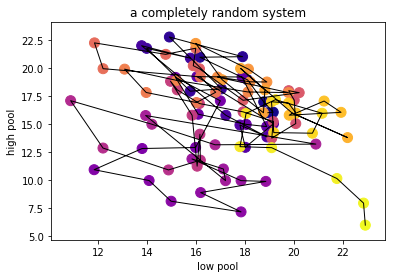

<Figure size 432x288 with 0 Axes>

In [202]:
agents = list()

for i in range(50):
    agents.append(randomagent())

statespace(agents,"a completely random system")

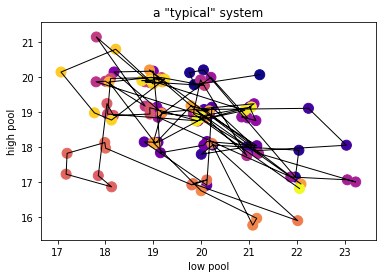

<Figure size 432x288 with 0 Axes>

In [212]:
agents = list()

for i in range(6):
    agents.append(stableagent())
for i in range(12):
    agents.append(lowagent())
for i in range(12):
    agents.append(highagent())
for i in range(10):
    agents.append(randomagent())
for i in range(10):
    agents.append(nashagent())
    
statespace(agents,"a \"typical\" system")

We'll plot the state space with a line to show the relationship from time step to time step, as well as dots that go from purple to yellow over time to show how the system changes over longer periods of time. Noise is added to each point to distinguish multiple points at the same location.

Comparing the random and typical state spaces, notice that the random state space spans more of the whole space, and that the typical space is more structured, with big fluctuations early on before oscillating around (18,23) despite only 1/5 of the agents being rational.

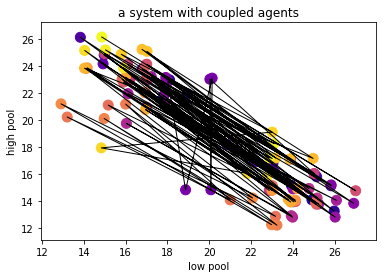

<Figure size 432x288 with 0 Axes>

In [213]:
agents = list()

for i in range(5):
    agents.append(stableagent())
for i in range(10):
    agents.append(lowagent())
for i in range(10):
    agents.append(highagent())
for i in range(17):
    agents.append(randomagent())
for i in range(8):
    agents.append(couplednashagent())
    
statespace(agents,"a system with coupled agents")

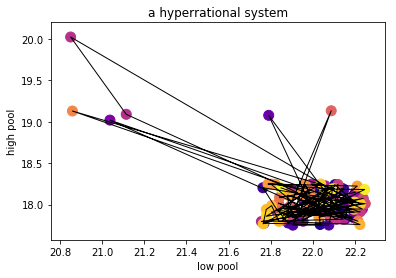

<Figure size 432x288 with 0 Axes>

In [214]:
agents = list()
for i in range(50):
    agents.append(nashagent())
    
statespace(agents,"a hyperrational system")

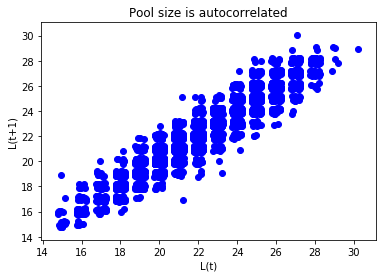

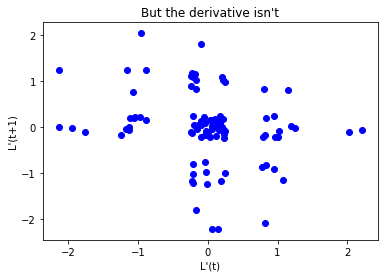

<Figure size 432x288 with 0 Axes>

In [94]:
agents = list()

for i in range(np.random.randint(2,7)):
    agents.append(stableagent())
for i in range(np.random.randint(4,14)):
    agents.append(lowagent())
for i in range(np.random.randint(4,14)):
    agents.append(highagent())
for i in range(np.random.randint(4,14)):
    agents.append(randomagent())
for i in range(50-len(agents)):
    agents.append(nashagent())

for i in range(50):
    sample = np.array(samplegen(agents))

    s_t0 = sample[:-1,1]+np.random.uniform(-0.25,0.25,(99))
    s_t1 = sample[1:,1]++np.random.uniform(-0.25,0.25,(99))

    plt.scatter(s_t0,s_t1,c='b')
plt.xlabel('L(t)')
plt.ylabel('L(t+1)')
plt.title('Pool size is autocorrelated')
plt.show()
plt.clf()

for i in range(50):
    sample = np.array(samplegen(agents))

    s_t0 = np.diff(sample[:-1,1])+np.random.uniform(-0.25,0.25,(98))
    s_t1 = np.diff(sample[1:,1])+np.random.uniform(-0.25,0.25,(98))

plt.scatter(s_t0,s_t1,c='b')
plt.xlabel("L'(t)")
plt.ylabel("L'(t+1)")
plt.title("But the derivative isn't")
plt.show()
plt.clf()

The fact that L(t) gives us some information about L(t+1) seems helpful, but when we look at the change from time step to time step we realize that this is just because the system can only move so far in one time step, so we can't make use this to make useful predictions. In other words, we know what kind of behavior to expect in general, but we can't predict the behavior from time step to time step.

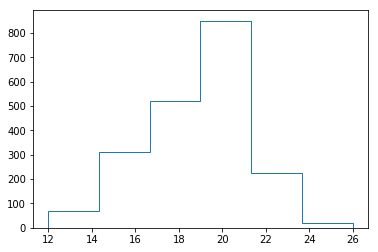

covariance matrix for low and high pools
[[ 6.43366458 -0.43136343]
 [-0.43136343  5.49359455]]
low mean
18.699
high mean
18.148


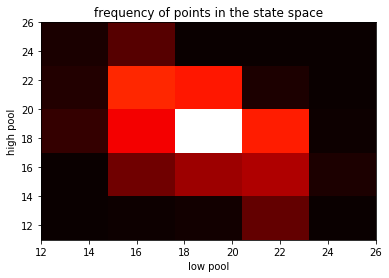

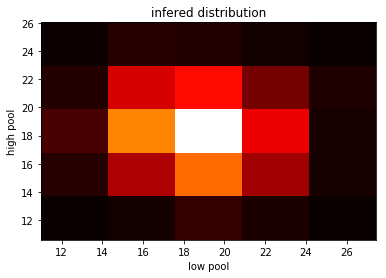

In [183]:
agents = list()

for i in range(np.random.randint(2,7)):
    agents.append(stableagent())
for i in range(np.random.randint(4,14)):
    agents.append(lowagent())
for i in range(np.random.randint(4,14)):
    agents.append(highagent())
for i in range(np.random.randint(4,14)):
    agents.append(randomagent())
for i in range(50-len(agents)):
    agents.append(nashagent())
    
sample = np.array(samplegen(agents))
for i in range(19):
    sample = np.concatenate((sample,np.array(samplegen(agents))),0)


plt.hist(sample[:,1],6,histtype='step')
plt.show()
plt.clf()

mean = [np.mean(sample[:,1]),np.mean(sample[:,2])]
cov = np.cov(np.reshape(sample[:,1:],(2,2000)))

cov[0,1] = -cov[0,1]
cov[1,0] = -cov[1,0]

print("covariance matrix for low and high pools")
print(cov)
print("low mean")
print(mean[0])
print("high mean")
print(mean[1])

x, y = np.random.multivariate_normal(mean, cov, 2000).T

plt.hist2d(sample[:,1],sample[:,2],[5,5],cmap='hot')
plt.xlabel("low pool")
plt.ylabel("high pool")
plt.title("frequency of points in the state space")
plt.show()
plt.clf()

plt.hist2d(x,y,[5,5],cmap='hot')
plt.xlabel("low pool")
plt.ylabel("high pool")
plt.title("infered distribution")
plt.show()



My agent will model the system by making an (unreasonable) Markov assumption that the state at time t is independent from the state at time t-1. It then makes a Bayesian prior assumption that the state at each step is drawn from a bivariate gaussian distribution, and infers a distribution from the available data. The central limit theorem and the experimental observations above suggest that it is reasonable to assume that the data is drawn from a gaussian distribution.

[[12 23 15]
 [12 22 16]
 [14 20 16]
 [15 20 15]
 [15 20 15]
 [16 20 14]
 [15 19 16]
 [13 21 16]
 [12 20 18]
 [11 21 18]
 [14 19 17]
 [13 21 16]
 [13 20 17]
 [13 20 17]
 [14 18 18]
 [15 19 16]
 [15 18 17]
 [14 20 16]
 [15 19 16]
 [16 17 17]
 [15 18 17]
 [14 19 17]
 [13 21 16]
 [12 22 16]
 [14 20 16]
 [13 20 17]
 [11 23 16]
 [13 23 14]
 [15 22 13]
 [14 23 13]
 [12 25 13]
 [12 26 12]
 [13 24 13]
 [13 24 13]
 [12 22 16]
 [12 24 14]
 [12 21 17]
 [13 21 16]
 [13 21 16]
 [11 22 17]
 [11 23 16]
 [12 23 15]
 [13 22 15]
 [12 21 17]
 [13 19 18]
 [13 20 17]
 [12 22 16]
 [11 22 17]
 [12 19 19]
 [12 18 20]
 [14 19 17]
 [13 20 17]
 [15 19 16]
 [14 20 16]
 [14 20 16]
 [15 19 16]
 [15 20 15]
 [15 20 15]
 [14 20 16]
 [13 21 16]
 [14 20 16]
 [15 19 16]
 [16 19 15]
 [14 21 15]
 [13 22 15]
 [15 19 16]
 [16 19 15]
 [17 19 14]
 [15 20 15]
 [16 20 14]
 [16 21 13]
 [16 22 12]
 [17 20 13]
 [17 19 14]
 [17 20 13]
 [17 19 14]
 [17 19 14]
 [15 18 17]
 [17 17 16]
 [17 19 14]
 [17 19 14]
 [17 19 14]
 [18 19 13]
 [18

C:\Users\Ross\Anaconda2\envs\env\lib\site-packages\matplotlib\legend.py:593: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x000001792403C8D0> has a label of '_collection0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
C:\Users\Ross\Anaconda2\envs\env\lib\site-packages\matplotlib\legend.py:593: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x0000017921C247F0> has a label of '_collection1' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
C:\Users\Ross\Anaconda2\envs\env\lib\site-packages\matplotlib\legend.py:593: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x000001792403CAC8> has a label of '_collection2' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


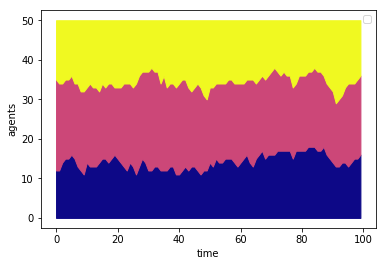

In [245]:
agents = list()

for i in range(5):
    agents.append(stableagent())
for i in range(10):
    agents.append(lowagent())
for i in range(10):
    agents.append(highagent())
for i in range(15):
    agents.append(randomagent())
for i in range(10):
    agents.append(nashagent())
    
sample = np.array(samplegen(agents))
print(sample)

cmap = matplotlib.cm.get_cmap('plasma')

low = plt.fill_between([t for t in range(0,100)],sample[:,0],0,color=cmap(0.0))
stable = plt.fill_between([t for t in range(0,100)],sample[:,0],sample[:,0]+sample[:,1],color=cmap(0.5))
high = plt.fill_between([t for t in range(0,100)],sample[:,0]+sample[:,1],50,color=cmap(1.0))

plt.xlabel('time')
plt.ylabel('agents')

plt.legend(handles=[low,stable,high])
plt.savefig("timeseries.png",dpi=600)